In [10]:
# ====================================================================
# 0. Import Libraries and Load Data
# ====================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")

# Load the dataset
try:
    df = pd.read_csv("C:/Users/Fernado/Desktop/ML_Project/data/raw/water_quality.csv")
    print("✅ Dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'data/raw/water_quality.csv' not found.")
    df = pd.DataFrame()

✅ Dataset loaded successfully.


## Phase 2: Data Preparation & Modeling
---
This notebook covers the data preprocessing and baseline model training steps. We will:
1. Select the features identified in the EDA phase.
2. Encode the target variable.
3. Split the data into stratified training and testing sets.
4. Apply Min-Max scaling to the features.
5. Train and evaluate several baseline classification models.

In [11]:
# ====================================================================
# 1. Feature and Target Selection
# ====================================================================
if not df.empty:
    # Based on the correlation analysis from Phase 1
    features = ['EC', 'Cl', 'TDS', 'Na']
    target = 'Water Quality Classification'

    X = df[features]
    y = df[target]

    print("Selected Features (X):")
    print(X.head())
    print("\nTarget Variable (y):")
    print(y.head())

Selected Features (X):
        EC      Cl    TDS      Na
0  16640.0  5176.0  11149  3535.0
1    299.0    21.0    262    39.0
2   1315.0   120.5    372    88.3
3    715.0    50.0    479    47.0
4    270.0    14.0    262    23.0

Target Variable (y):
0    Unsuitable for Drinking
1                       Good
2    Very Poor yet Drinkable
3                       Poor
4                       Good
Name: Water Quality Classification, dtype: object


In [12]:
# ====================================================================
# 2. Encode the Categorical Target Variable
# ====================================================================
if not df.empty:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    print("\nOriginal Target Labels:", le.classes_)
    print("Encoded Target Labels:", np.unique(y_encoded))
    # Storing class names for later use in plots
    class_names = le.classes_


Original Target Labels: ['Excellent' 'Good' 'Poor' 'Unsuitable for Drinking'
 'Very Poor yet Drinkable']
Encoded Target Labels: [0 1 2 3 4]


In [13]:
# ====================================================================
# 3. Stratified Train-Test Split
# ====================================================================
# We use an 80/20 split and stratify by the encoded target variable `y_encoded`
# to ensure the class distribution is the same in both train and test sets.
if not df.empty:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded
    )

    print("Shape of training data (X_train):", X_train.shape)
    print("Shape of testing data (X_test):", X_test.shape)

Shape of training data (X_train): (15223, 4)
Shape of testing data (X_test): (3806, 4)


In [14]:
# ====================================================================
# 4. Feature Scaling (Min-Max Scaler)
# ====================================================================
if not df.empty:
    scaler = MinMaxScaler()

    # Fit the scaler on the training data and transform it
    X_train_scaled = scaler.fit_transform(X_train)

    # Use the same fitted scaler to transform the test data
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled arrays back to DataFrames for clarity
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

    print("\nScaled Training Data Head:")
    print(X_train_scaled.head())


Scaled Training Data Head:
         EC        Cl       TDS        Na
0  0.058114  0.014104  0.058344  0.041973
1  0.030978  0.008362  0.036497  0.003953
2  0.108453  0.036445  0.103618  0.046302
3  0.001404  0.000474  0.020900  0.000734
4  0.052608  0.025711  0.049820  0.012987


--- Training Logistic Regression ---

✅ Results for Logistic Regression:
Accuracy: 0.7869
Classification Report:
                         precision    recall  f1-score   support

              Excellent       0.00      0.00      0.00       153
                   Good       0.00      0.00      0.00       326
                   Poor       0.61      0.99      0.76      1063
Unsuitable for Drinking       0.92      0.99      0.95      1322
Very Poor yet Drinkable       0.97      0.67      0.79       942

               accuracy                           0.79      3806
              macro avg       0.50      0.53      0.50      3806
           weighted avg       0.73      0.79      0.74      3806

✅ Confusion matrix saved to reports/figures/confusion_matrix_Logistic_Regression.png


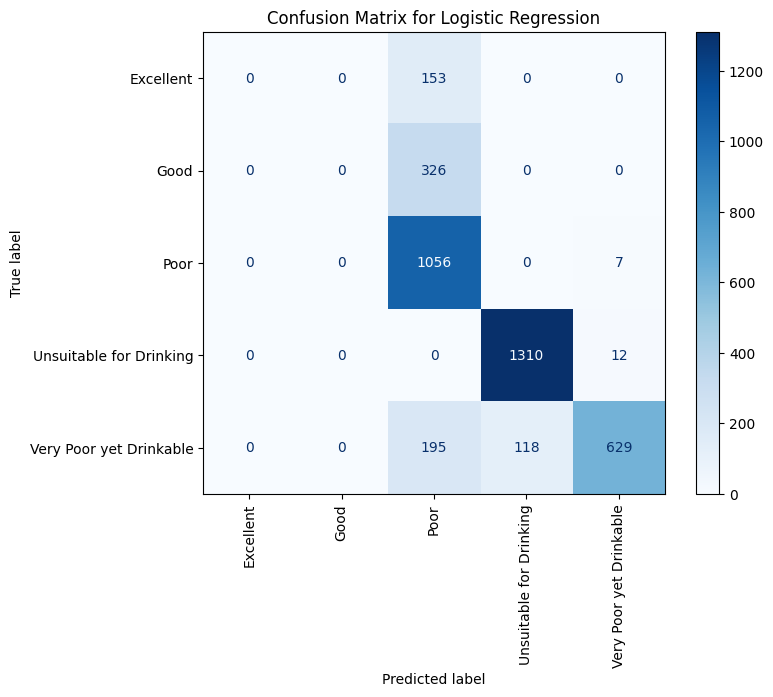

--- Training K-Nearest Neighbors ---

✅ Results for K-Nearest Neighbors:
Accuracy: 0.9619
Classification Report:
                         precision    recall  f1-score   support

              Excellent       0.93      0.96      0.95       153
                   Good       0.93      0.94      0.93       326
                   Poor       0.97      0.95      0.96      1063
Unsuitable for Drinking       0.98      0.98      0.98      1322
Very Poor yet Drinkable       0.95      0.95      0.95       942

               accuracy                           0.96      3806
              macro avg       0.95      0.96      0.95      3806
           weighted avg       0.96      0.96      0.96      3806

✅ Confusion matrix saved to reports/figures/confusion_matrix_K-Nearest_Neighbors.png


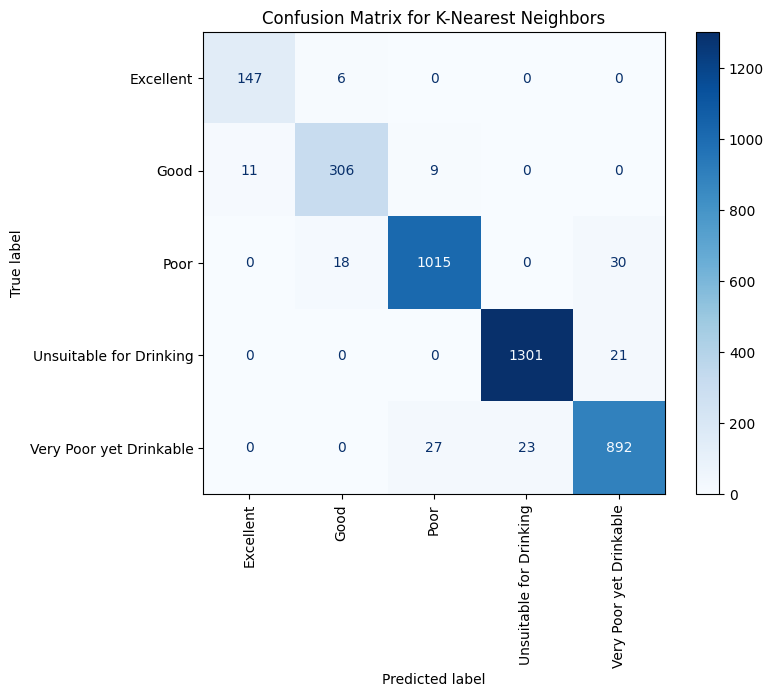

--- Training Naïve Bayes ---

✅ Results for Naïve Bayes:
Accuracy: 0.8061
Classification Report:
                         precision    recall  f1-score   support

              Excellent       0.89      0.92      0.91       153
                   Good       0.78      0.88      0.83       326
                   Poor       0.88      0.85      0.87      1063
Unsuitable for Drinking       0.95      0.70      0.81      1322
Very Poor yet Drinkable       0.63      0.85      0.73       942

               accuracy                           0.81      3806
              macro avg       0.83      0.84      0.83      3806
           weighted avg       0.83      0.81      0.81      3806

✅ Confusion matrix saved to reports/figures/confusion_matrix_Naïve_Bayes.png


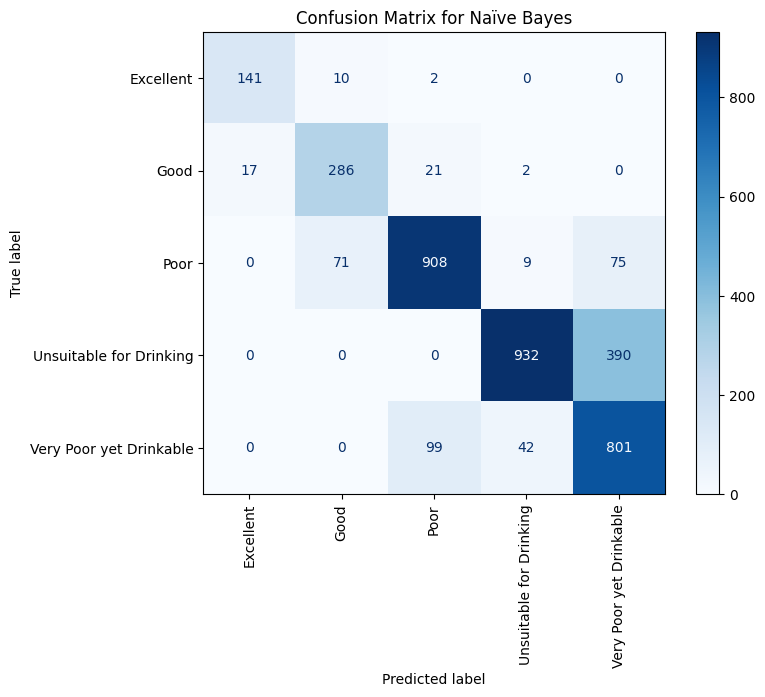

--- Training Random Forest ---

✅ Results for Random Forest:
Accuracy: 0.9677
Classification Report:
                         precision    recall  f1-score   support

              Excellent       0.95      0.94      0.94       153
                   Good       0.93      0.95      0.94       326
                   Poor       0.97      0.96      0.97      1063
Unsuitable for Drinking       0.98      0.99      0.99      1322
Very Poor yet Drinkable       0.96      0.95      0.96       942

               accuracy                           0.97      3806
              macro avg       0.96      0.96      0.96      3806
           weighted avg       0.97      0.97      0.97      3806

✅ Confusion matrix saved to reports/figures/confusion_matrix_Random_Forest.png


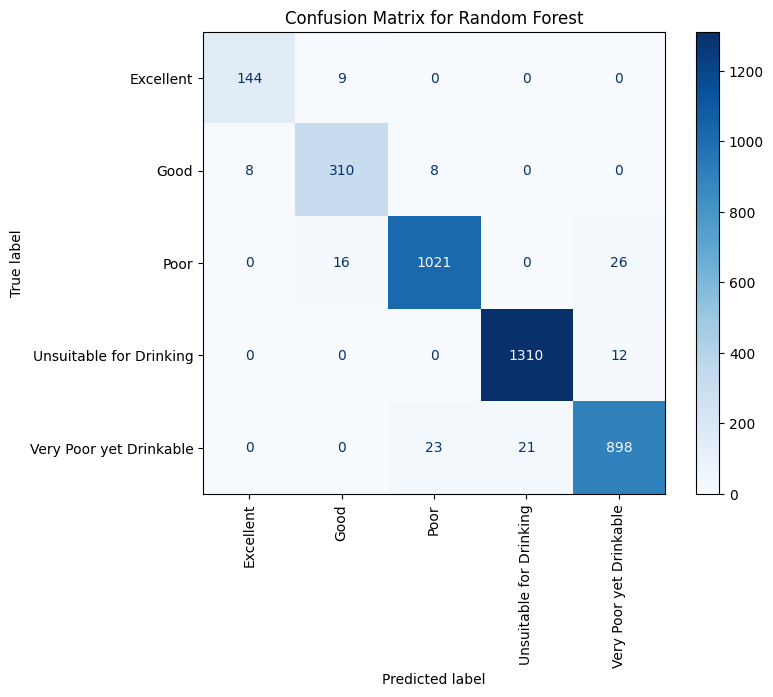

--- Training Gradient Boosting ---

✅ Results for Gradient Boosting:
Accuracy: 0.9687
Classification Report:
                         precision    recall  f1-score   support

              Excellent       0.96      0.95      0.95       153
                   Good       0.93      0.96      0.95       326
                   Poor       0.97      0.96      0.97      1063
Unsuitable for Drinking       0.99      0.99      0.99      1322
Very Poor yet Drinkable       0.96      0.96      0.96       942

               accuracy                           0.97      3806
              macro avg       0.96      0.96      0.96      3806
           weighted avg       0.97      0.97      0.97      3806

✅ Confusion matrix saved to reports/figures/confusion_matrix_Gradient_Boosting.png


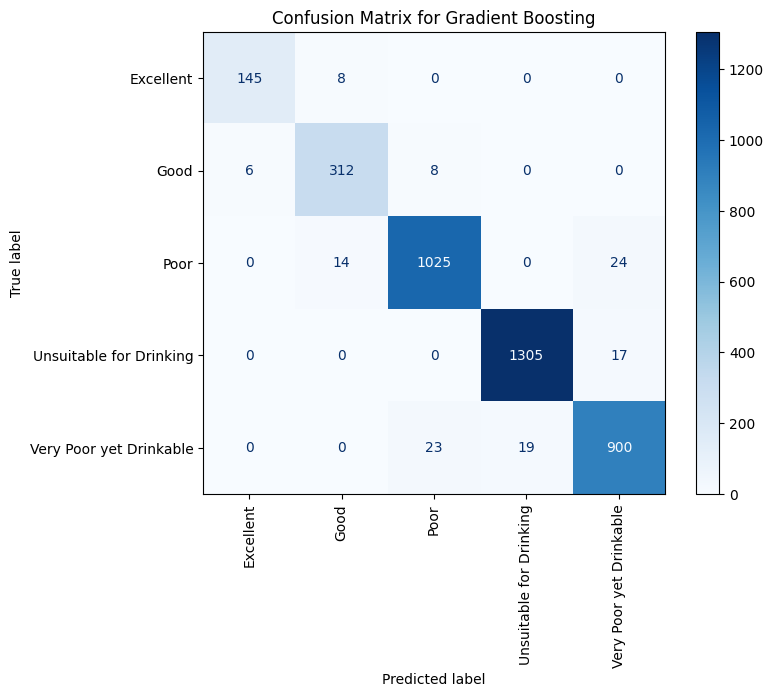

--- Training MLP Classifier (Perceptron) ---

✅ Results for MLP Classifier (Perceptron):
Accuracy: 0.9727
Classification Report:
                         precision    recall  f1-score   support

              Excellent       0.96      0.96      0.96       153
                   Good       0.95      0.97      0.96       326
                   Poor       0.98      0.97      0.97      1063
Unsuitable for Drinking       0.99      0.99      0.99      1322
Very Poor yet Drinkable       0.96      0.96      0.96       942

               accuracy                           0.97      3806
              macro avg       0.97      0.97      0.97      3806
           weighted avg       0.97      0.97      0.97      3806

✅ Confusion matrix saved to reports/figures/confusion_matrix_MLP_Classifier_(Perceptron).png


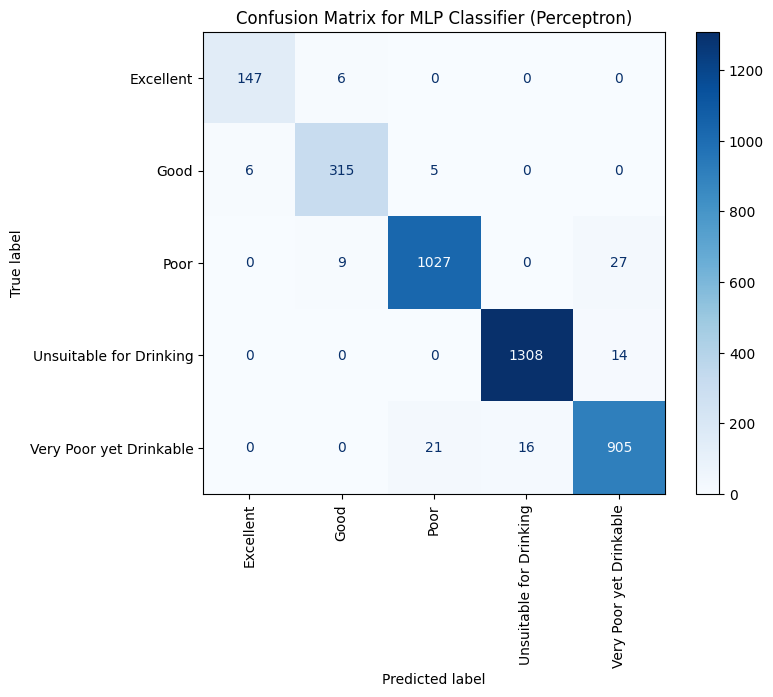

In [15]:
# ====================================================================
# 5. Model Training and Baseline Evaluation
# ====================================================================

# Dictionary to hold the models we want to train
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naïve Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "MLP Classifier (Perceptron)": MLPClassifier(random_state=42, max_iter=1000)
}

# Dictionary to store results
results = {}

if not df.empty:
    for name, model in models.items():
        print(f"--- Training {name} ---")
        
        # Train the model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=class_names)
        
        # Store results
        results[name] = accuracy
        
        print(f"\n✅ Results for {name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(report)
        
        # Visualize the Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
        ax.set_title(f'Confusion Matrix for {name}')
        
        # Save the figure
        cm_path = f'reports/figures/confusion_matrix_{name.replace(" ", "_")}.png'
        plt.savefig(cm_path, bbox_inches='tight')
        print(f"✅ Confusion matrix saved to {cm_path}")
        
        plt.show()

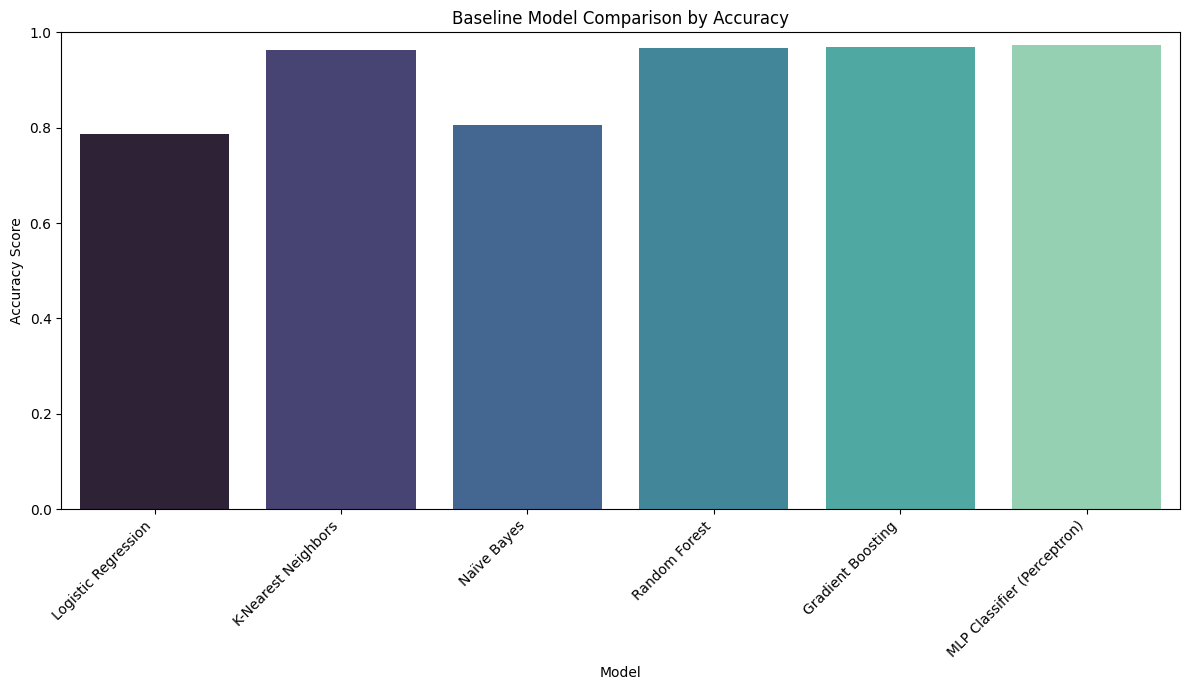


🏆 Best Performing Model (by Accuracy): MLP Classifier (Perceptron) with an accuracy of 0.9727


In [16]:
# ====================================================================
# 6. Compare Model Performance
# ====================================================================
if results:
    plt.figure(figsize=(12, 7))
    sns.barplot(x=list(results.keys()), y=list(results.values()), palette='mako')
    plt.title('Baseline Model Comparison by Accuracy')
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    best_model_name = max(results, key=results.get)
    print(f"\n🏆 Best Performing Model (by Accuracy): {best_model_name} with an accuracy of {results[best_model_name]:.4f}")


✅ Feature importance plot saved to reports/figures/feature_importance_Random_Forest.png


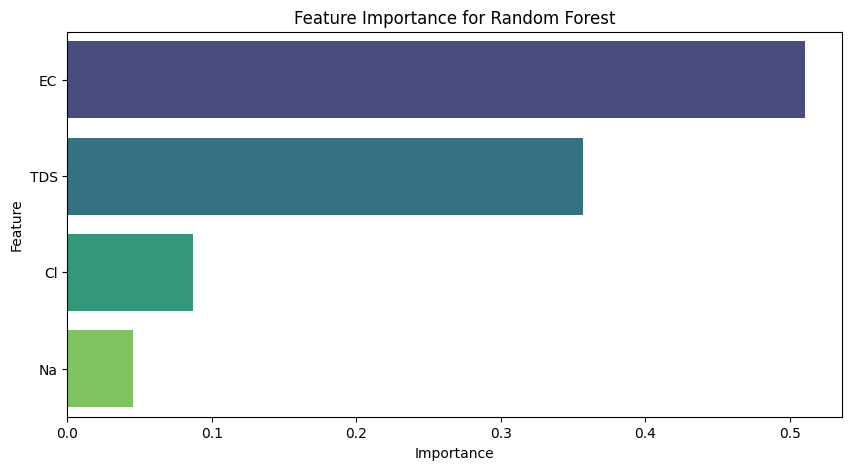

✅ Feature importance plot saved to reports/figures/feature_importance_Gradient_Boosting.png


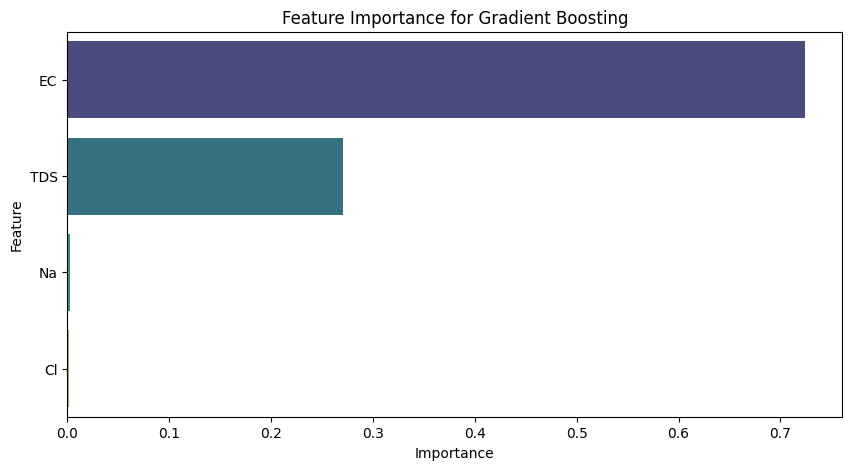

In [17]:
# ====================================================================
# 7. Feature Importance Analysis (for best tree-based models)
# ====================================================================
# Let's analyze feature importance for Random Forest and Gradient Boosting

tree_models = {
    "Random Forest": models.get("Random Forest"),
    "Gradient Boosting": models.get("Gradient Boosting")
}

if tree_models["Random Forest"]: # Check if models were trained
    for name, model in tree_models.items():
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(10, 5))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Feature Importance for {name}')
        
        # Save the figure
        fi_path = f'reports/figures/feature_importance_{name.replace(" ", "_")}.png'
        plt.savefig(fi_path, bbox_inches='tight')
        print(f"✅ Feature importance plot saved to {fi_path}")
        
        plt.show()

### Analysis of Model Performance & Feature Importance

1.  **The Top Tier: MLP, Gradient Boosting & Random Forest**
    * **MLP Classifier (Perceptron):** Emerged as the surprising winner with the highest accuracy at **97.27%**. Its performance is outstanding across all classes, achieving a near-perfect macro average F1-score of 0.97. This indicates it was highly effective at learning the complex patterns in the data.
    * **Gradient Boosting & Random Forest:** These two powerful ensemble models are right behind, with accuracies of **96.87%** and **96.77%**, respectively. Their classification reports show extreme robustness and ability to handle all classes well.

2.  **The Strong Contender: K-Nearest Neighbors**
    * KNN also performed exceptionally well (**96.19%** accuracy), proving to be a very capable model for this dataset with balanced F1-scores above 0.93 for all classes.

3.  **The Middle Ground & Underperformer**
    * **Naïve Bayes** provided a respectable accuracy of **80.61%** but struggled with some classes.
    * **Logistic Regression** clearly failed, scoring **0.00** for precision and recall on the "Excellent" and "Good" classes, making it unsuitable for this problem.

4.  **Feature Importance Insights**
    * The feature importance plots from both Random Forest and Gradient Boosting provide a clear and consistent story.
    * **`EC` (Electrical Conductivity) is overwhelmingly the most important feature** for predicting water quality. The Gradient Boosting model attributes over 70% of its decision-making power to this single feature.
    * **`TDS` (Total Dissolved Solids) is the clear second most important feature.** This is logical, as EC and TDS are physically related properties.
    * The other two features, `Cl` (Chloride) and `Na` (Sodium), have a much smaller impact, especially in the highly decisive Gradient Boosting model. This tells us that a huge amount of the predictive signal is contained within just the EC and TDS measurements.


---
### End of Phase 2

*Summary & Conclusion for Phase 2*

The baseline model evaluation has been highly successful, revealing a clear distinction between model capabilities.

**Key Findings:**

* **Ensemble Models and Neural Networks Excel:** The tree-based ensembles (Random Forest, Gradient Boosting) and the simple neural network (MLP Classifier) proved vastly superior. Their ability to model complex, non-linear relationships allowed them to overcome the challenges of class imbalance and achieve outstanding performance (~97% accuracy).
* **Simpler Models Struggle:** The linear model (Logistic Regression) was incapable of handling the task, while the probabilistic model (Naïve Bayes) showed noticeable weaknesses despite its decent overall accuracy.
* **Feature Set is Highly Predictive:** The fact that multiple models could achieve such high accuracy using only four features (`EC`, `Cl`, `TDS`, `Na`) confirms that our feature selection in Phase 1 was highly effective.

**Decision for Phase 3:**

Based on these results, we have three excellent candidates for the final optimization phase: **MLP Classifier**, **Gradient Boosting**, and **Random Forest**.

While the MLP Classifier had the highest accuracy, **Gradient Boosting is an ideal choice to move forward with.** It is a state-of-the-art model for tabular data, is highly tunable, and its results were nearly identical to the MLP. It represents a robust and industry-standard choice for optimization.
